# 变分量子线路梯度计算进阶

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.7.0rc1/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.7.0rc1/mindquantum/zh_cn/advanced/mindspore_get_gradient_of_PQC_with_mindquantum.ipynb)&emsp;
[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.7.0rc1/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.7.0rc1/mindquantum/zh_cn/advanced/mindspore_get_gradient_of_PQC_with_mindquantum.py)&emsp;
[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.7.0rc1/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/r2.7.0rc1/docs/mindquantum/docs/source_zh_cn/advanced/get_gradient_of_PQC_with_mindquantum.ipynb)

在MindSpore Quantum中，我们可以通过 [Simulator](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html) 类的[get_expectation_with_grad](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.get_expectation_with_grad) 方法来获得一个变分量子线路的梯度，在这篇教程中，我们将更进一步的介绍该方法的其他功能，帮助大家来实现更高级的使用方法。

## 模型介绍

[get_expectation_with_grad](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.get_expectation_with_grad) 方法主要是用来计算如下表达式的值和线路中参数的梯度。

$$E(\boldsymbol{\theta})=\left<\varphi\right|U^\dagger_l(\boldsymbol{\theta})HU_r(\boldsymbol{\theta})\left|\psi\right>$$

该方法的接口定义如下

```python
Simulator.get_expectation_with_grad(
    hams,
    circ_right,
    circ_left=None,
    simulator_left=None,
    parallel_worker=None
)
```

下面，我们将一一介绍每个参数的意义。

1. `hams`。线路中的哈密顿量，所需要的类型为MindSpore Quantum中的 [Hamiltonian](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/core/operators/mindquantum.core.operators.Hamiltonian.html)，或者一个包含多个 [Hamiltonian](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/core/operators/mindquantum.core.operators.Hamiltonian.html) 的`list`数组，对于后一种情况，框架会同时计算出线路关于所有哈密顿量的期望值，和每个期望值关于线路参数的梯度

2. `circ_right`。为公式中的$U_r(\boldsymbol{\theta})$

3. `circ_left`。为公式中的$U_l(\boldsymbol{\theta})$，当为默认值`None`时，`circ_left`和`circ_right`为同一线路，若需要空线路可单独使用[Circuit()](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/core/circuit/mindquantum.core.circuit.Circuit.html)创建。

4. `simulator_left`。为包含公式中$\left|\varphi\right>$的模拟器，你可以通过模拟器的 [set_qs](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.set_qs)、[apply_gate](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.apply_gate) 或 [apply_circuit](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.apply_circuit) 方法来设置该模拟器的状态为你需要的状态。当为默认值`None`时，$\left|\varphi\right>=\left|\psi\right>$，而$\left|\psi\right>$为当前模拟器所包含的量子态。

5. `parallel_worker`。当`hams`包含多个哈密顿量或者encoder的输入包含多个样本点时，MindSpore Quantum会根据此整数为参考来合理地进行并行运算。

在MindSpore Quantum中，量子线路中的参数可以是encoder参数，用于将经典数据编码成量子态，类似于经典神经网络中的输入部分，encoder参数接受一个二维数据，第一个维度表示样本点个数，第二个维度表示经典数据的特征数，相当于经典机器学习中的一个batch；另一部分参数可以是ansatz参数，类似于经典神经网络中的训练参数，用于训练出特定的量子线路。下面我们构建一个既含有encoder参数又含有ansatz参数的量子线路。

In [1]:
from mindquantum.core.circuit import Circuit

circ1 = Circuit().rx('a', 0).as_encoder()                       # 将量子线路设置成encoder线路
circ2 = Circuit().ry('b', 0).as_ansatz()                        # 将量子线路设置成ansatz线路，默认情况，所有量子线路都是ansatz线路。
circ3 = Circuit().rz('c', 0).as_encoder()  # 将量子线路设置成encoder线路

circ = circ1 + circ2 + circ3
print(f"encoder parameters: {circ.encoder_params_name}")
print(f"ansatz parameters: {circ.ansatz_params_name}")

encoder parameters: ['a', 'c']
ansatz parameters: ['b']


下面我们利用MindSpore Quantum来计算上述量子线路关于哈密顿量 $Z$的期望值。首先我们定义问题哈密顿量。

In [2]:
from mindquantum.core.operators import QubitOperator                   # 导入QubitOperator模块，生成泡利算符
from mindquantum.core.operators import Hamiltonian                     # 导入Hamiltonian模块，生成哈密顿量

ham = Hamiltonian(QubitOperator('Z0'))
print(ham)

1 [Z0]


接下来，我们利用MindSpore Quantum生成计算期望值和期望值关于各个参数导数的算符。

In [3]:
from mindquantum.simulator import Simulator

sim = Simulator('mqvector', 1)
grad_ops = sim.get_expectation_with_grad(ham, circ)
print(grad_ops)

这里我们计算 $a=1, b=2, c=3$时，线路关于泡利$Z$算符的期望值。根据上述说明，我们选择encoder数据为 `[[1, 3]]`，第一个维度表示经典数据样本点个数，第二个维度表示有两个经典特征，分别为`a`和`c`；选择待训练参数 $b$ 的初始值为`[2]`。

In [4]:
import numpy as np

encoder_data = np.array([[1, 3]])
ansatz_data = np.array([2])
f, g_e, g_a = grad_ops(encoder_data, ansatz_data)
print(f"expectation value:\n{f}\n with shape {f.shape}")
print(
    f"gradient value w.r.t encoder parametres:\n{g_e}\n with shape {g_e.shape}")
print(
    f"gradient value w.r.t ansatz parametres:\n{g_a}\n with shape {g_a.shape}")

expectation value:
[[-0.2248451+0.j]]
 with shape (1, 1)
gradient value w.r.t encoder parametres:
[[[0.35017549+0.j 0.        +0.j]]]
 with shape (1, 1, 2)
gradient value w.r.t ansatz parametres:
[[[-0.4912955+0.j]]]
 with shape (1, 1, 1)


为了验证encoder数据可以同时取不同的样本点，我们同时计算$a=1, c=3$和$a=4, c=5$时的期望值和梯度。

In [5]:
encoder_data = np.array([[1, 3], [4, 5]])
ansatz_data = np.array([2])
f, g_e, g_a = grad_ops(encoder_data, ansatz_data)
print(f"expectation value:\n{f}\n with shape {f.shape}")
print(
    f"gradient value w.r.t encoder parametres:\n{g_e}\n with shape {g_e.shape}")
print(f"gradient value w.r.t ansatz parametres:\n{g_a}\n with shape {g_a.shape}")


expectation value:
[[-0.2248451 +0.j]
 [ 0.27201173+0.j]]
 with shape (2, 1)
gradient value w.r.t encoder parametres:
[[[ 0.35017549+0.j  0.        +0.j]]

 [[-0.31494096+0.j  0.        +0.j]]]
 with shape (2, 1, 2)
gradient value w.r.t ansatz parametres:
[[[-0.4912955 +0.j]]

 [[ 0.59435646+0.j]]]
 with shape (2, 1, 1)


### 期望值结果分析

在上述结果中，我们发现期望值是一个二维数组，维度为 $(2, 1)$，其中第一维表示样本点的个数，第二维表示哈密顿量的个数。在MindSpore Quantum中，我们除了能够批量的样本点外，还可以同时计算不同的哈密顿量关于线路的期望值和参数的导数。因此在上述结果中，当 $a=1, b=2, c=3$ 时，期望值为 $-0.2248451$，而当 $a=4, b=2, c=5$ 时，期望值为 $0.27201173$ 。

### 梯度分析

在上述结果中，我们发现期望值关于encoder参数的梯度是一个三维数组，维度为 $(2, 1, 2)$ ，其中第一维表示样本点个数，第二维表示哈密顿量个数，第三维表示encoder参数的个数。ansatz参数的梯度也是一个三维数组，维度为 $(2, 1, 1)$ ，其中第一维表示样本点个数，第二维表示哈密顿量个数，第三维表示ansatz参数的个数。

## 多个哈密顿量在多个输入样本点下的期望值

在本任务中，我们想计算如下量子线路在$\alpha=\text{arctan}(\sqrt{2}), \pi/2$时，关于哈密顿量$Z_0, X_0, Y_0$的期望值。

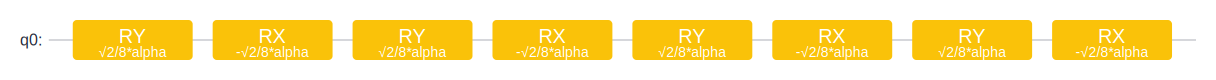

In [6]:
import numpy as np
from mindquantum.core.operators import QubitOperator, TimeEvolution, Hamiltonian
from mindquantum.simulator import Simulator
from mindquantum.core.circuit import Circuit
from mindquantum.core.gates import H

# 定义希尔伯特空间中的旋转轴
axis = QubitOperator('Y0', 1 / np.sqrt(2)) + QubitOperator('X0', -1 / np.sqrt(2))
# 定义trotter分解的阶数
trotter_order = 4
# 利用TimeEvolution来对旋转进行trotter分解
encoder = TimeEvolution(axis, {'alpha': 0.5 / trotter_order}).circuit * trotter_order
encoder.as_encoder()
encoder.svg()

下面定义待求期望值的哈密顿量：

In [7]:
# 定义哈密顿量集合
hams = [Hamiltonian(QubitOperator('X0')), Hamiltonian(QubitOperator('Y0')), Hamiltonian(QubitOperator('Z0'))]
hams

[1 [X0], 1 [Y0], 1 [Z0]]

获取求期望值和梯度的算子：

In [8]:
grad_ops = Simulator('mqvector', 1).get_expectation_with_grad(hams, encoder, parallel_worker=6)
grad_ops

定义`alpha`的值：

In [9]:
alpha = np.array([[np.arctan(np.sqrt(2))], [np.pi/2]])
alpha

array([[0.95531662],
       [1.57079633]])

In [10]:
f, g = grad_ops(alpha)
print(f)
print(f'shape: {f.shape}')
print('\n')
print(g)
print(f'shape: {g.shape}')

[[0.59389047+0.00000000e+00j 0.55828416+1.38777878e-17j
  0.57932107+0.00000000e+00j]
 [0.77269648+0.00000000e+00j 0.63465887-1.38777878e-17j
  0.01217645+0.00000000e+00j]]
shape: (2, 3)


[[[ 0.45790207+0.j]
  [ 0.35200884+0.j]
  [-0.80864423+0.j]]

 [[ 0.10989151+0.j]
  [-0.11512098+0.j]
  [-0.9732094 +0.j]]]
shape: (2, 3, 1)


### 结果分析

根据上面结果我们可以看到，期望值`f`的维度为`(2, 3)`，不难发现，`f`的每一行对应每一个样本点不同哈密顿量期望值，`f`的每一列对应每个哈密顿量在不同样本的下的期望值。而对于梯度`g`来说，我们也有相似的结论，只不过最后一个维度表示的是不同的线路参数。

## 计算不同量子态的内积

根据模型，我们只需将哈密顿量设置为单位算符，$U_l(\boldsymbol{\theta})$ 设置为空的量子线路，那么我们就可以利用 $U_r(\boldsymbol{\theta})$ 来将 $\left|\psi\right>$ 旋转到 $\left|\varphi\right>$上，而这需要计算出 $\left|\varphi\right>$和旋转后的量子态之间的内积。

这里，我们计算如下量子线路对零态进行演化过后的量子态与均匀叠加态之间的内积。

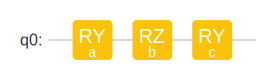

In [11]:
circuit = Circuit().ry('a', 0).rz('b', 0).ry('c', 0)
circuit.svg()

制备包含均匀叠加态的模拟器：

In [12]:
sim_l = Simulator('mqvector', 1)
sim_l.apply_gate(H.on(0))
sim_l

mqvector simulator with 1 qubit (little endian), dtype: mindquantum.complex128.
Current quantum state:
√2/2¦0⟩
√2/2¦1⟩

制备单位哈密顿量：

In [13]:
ham = Hamiltonian(QubitOperator(""))

获取内积和梯度计算算子：

In [14]:
grad_ops = Simulator('mqvector', 1).get_expectation_with_grad(ham, circuit, Circuit(), simulator_left=sim_l)

选择合适的参数：

In [15]:
rot_angle = np.array([7.902762e-01, 2.139225e-04, 7.795934e-01])

In [16]:
f, g = grad_ops(rot_angle)
print(f)
print('\n')
print(g)

[[0.99999989-7.52279618e-05j]]


[[[ 2.31681689e-04+3.80179652e-05j -5.34806192e-05-3.51659884e-01j
    2.31681689e-04-3.80179652e-05j]]]


### 结果分析

通过计算结果，我们发现最后两个态的内积接近与1，说明我们能够通过如上线路以很高的保真度制备均匀叠加态 $\left(\left|0\right> + \left|1\right>\right)/\sqrt{2}$。

In [17]:
print(circuit.get_qs(pr=rot_angle, ket=True))

(0.7074343486186319-0.00010695972396782116j)¦0⟩
(0.7067790538448511+√5/3906250j)¦1⟩


In [18]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')